# HOUSE PRICE PREDICTION - COMPLETE DATA SCIENCE PROJECT
# Advanced EDA, Feature Engineering, and ML Model Comparison

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
print("="*80)
print("LOADING DATA")
print("="*80)

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Save test IDs for submission
test_ids = test['Id']

LOADING DATA
Train shape: (1460, 81)
Test shape: (1459, 80)


In [4]:
print("\n" + "="*80)
print("INITIAL DATA EXPLORATION")
print("="*80)

print("\nFirst few rows of training data:")
print(train.head())

print("\nData types:")
print(train.dtypes.value_counts())

print("\nBasic statistics:")
print(train.describe())


INITIAL DATA EXPLORATION

First few rows of training data:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold


TARGET VARIABLE ANALYSIS


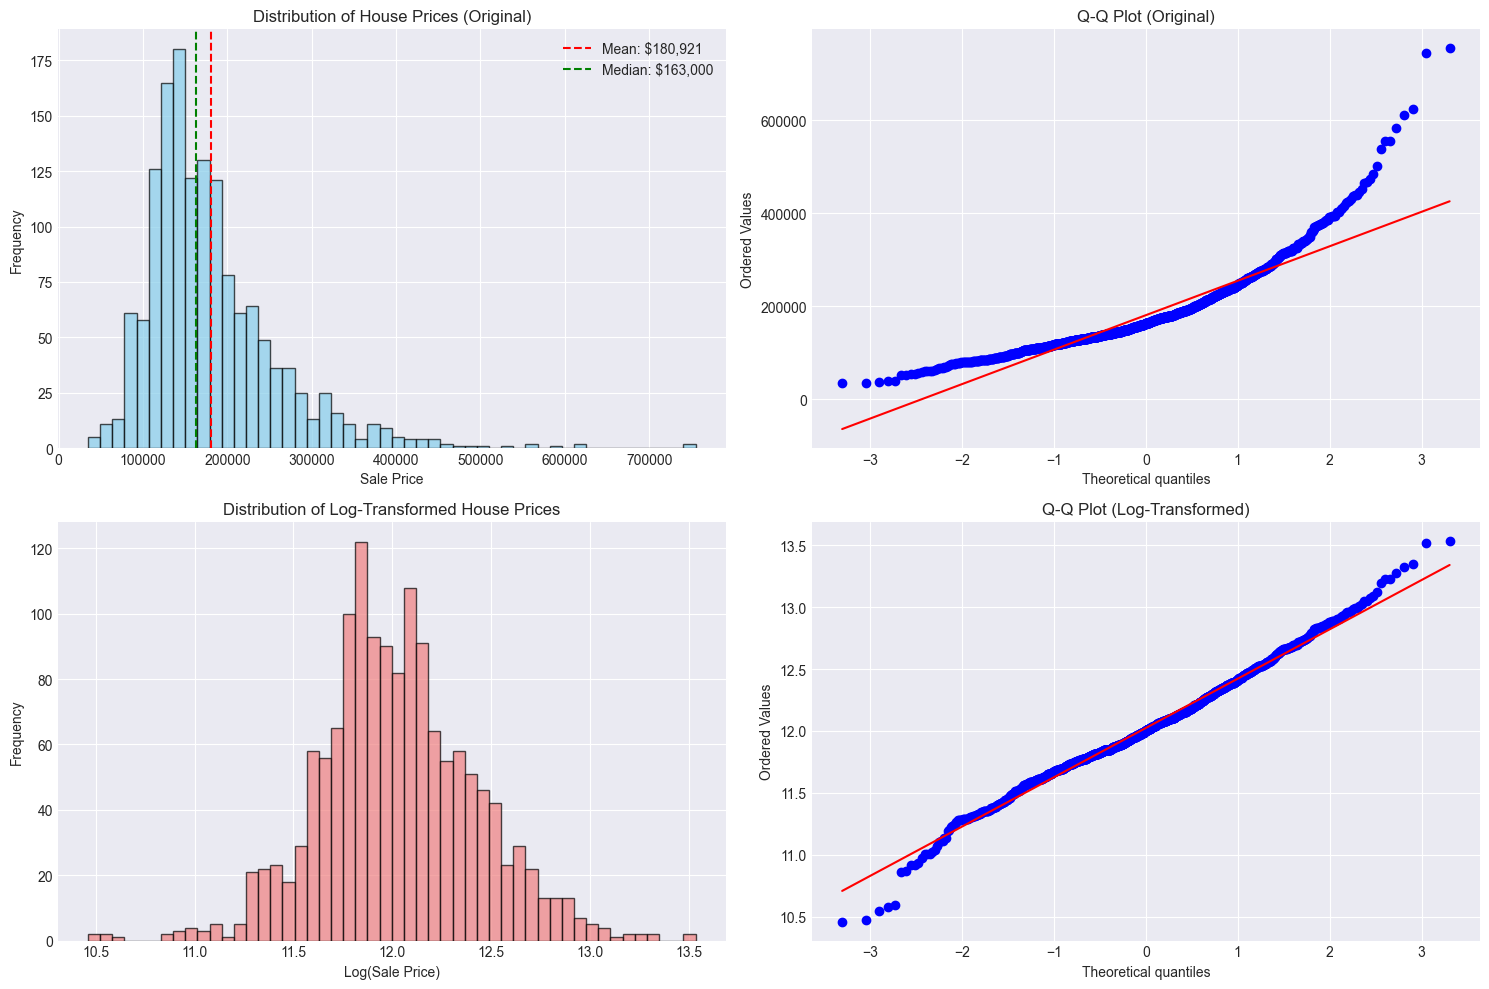


Original SalePrice Statistics:
Mean: $180,921.20
Median: $163,000.00
Std Dev: $79,442.50
Skewness: 1.883
Kurtosis: 6.536

Log-Transformed SalePrice Statistics:
Skewness: 0.121
Kurtosis: 0.810


In [5]:
print("\n" + "="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original distribution
axes[0, 0].hist(train['SalePrice'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Sale Price')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of House Prices (Original)')
axes[0, 0].axvline(train['SalePrice'].mean(), color='red', linestyle='--', 
                   label=f'Mean: ${train["SalePrice"].mean():,.0f}')
axes[0, 0].axvline(train['SalePrice'].median(), color='green', linestyle='--', 
                   label=f'Median: ${train["SalePrice"].median():,.0f}')
axes[0, 0].legend()

# QQ plot
stats.probplot(train['SalePrice'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Original)')

# Log-transformed distribution
log_saleprice = np.log1p(train['SalePrice'])
axes[1, 0].hist(log_saleprice, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1, 0].set_xlabel('Log(Sale Price)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Log-Transformed House Prices')

# QQ plot for log-transformed
stats.probplot(log_saleprice, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Log-Transformed)')

plt.tight_layout()
plt.show()

print(f"\nOriginal SalePrice Statistics:")
print(f"Mean: ${train['SalePrice'].mean():,.2f}")
print(f"Median: ${train['SalePrice'].median():,.2f}")
print(f"Std Dev: ${train['SalePrice'].std():,.2f}")
print(f"Skewness: {train['SalePrice'].skew():.3f}")
print(f"Kurtosis: {train['SalePrice'].kurtosis():.3f}")

print(f"\nLog-Transformed SalePrice Statistics:")
print(f"Skewness: {log_saleprice.skew():.3f}")
print(f"Kurtosis: {log_saleprice.kurtosis():.3f}")


MISSING VALUES ANALYSIS

Training Set - Total columns with missing values: 19

Top features with missing values:
              Missing Count  Percentage
PoolQC                 1453   99.520548
MiscFeature            1406   96.301370
Alley                  1369   93.767123
Fence                  1179   80.753425
MasVnrType              872   59.726027
FireplaceQu             690   47.260274
LotFrontage             259   17.739726
GarageType               81    5.547945
GarageYrBlt              81    5.547945
GarageFinish             81    5.547945
GarageQual               81    5.547945
GarageCond               81    5.547945
BsmtExposure             38    2.602740
BsmtFinType2             38    2.602740
BsmtQual                 37    2.534247
BsmtCond                 37    2.534247
BsmtFinType1             37    2.534247
MasVnrArea                8    0.547945
Electrical                1    0.068493


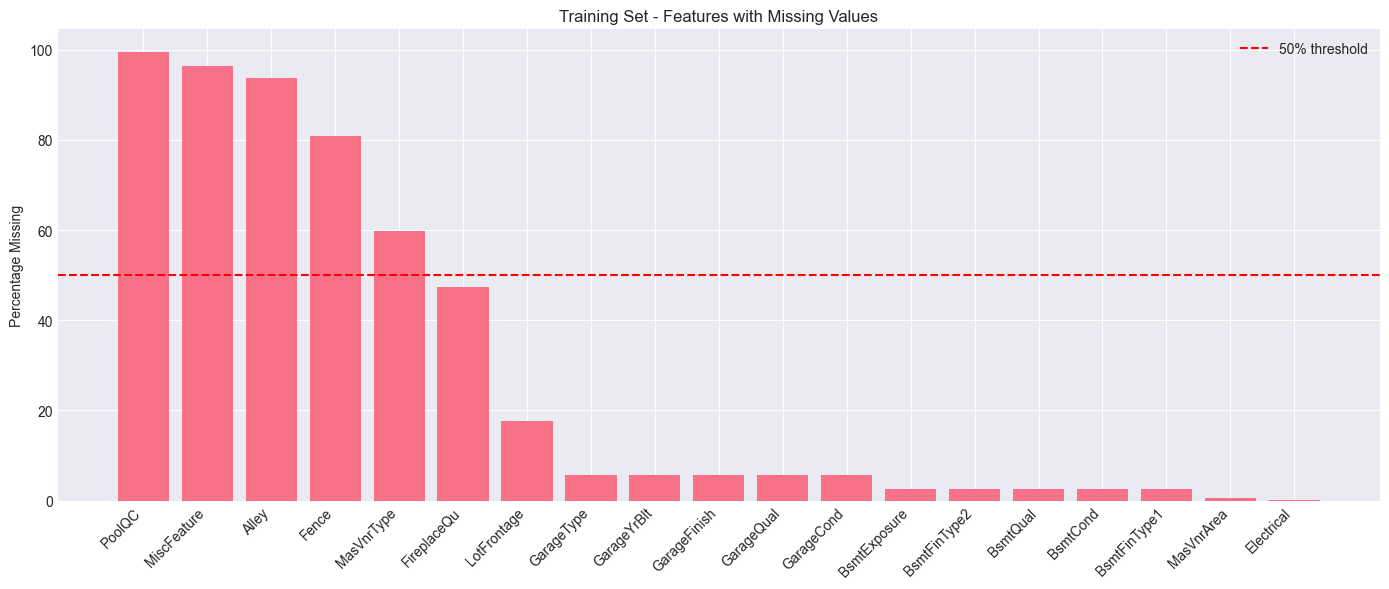


Test Set - Total columns with missing values: 33

Top features with missing values:
              Missing Count  Percentage
PoolQC                 1456   99.794380
MiscFeature            1408   96.504455
Alley                  1352   92.666210
Fence                  1169   80.123372
MasVnrType              894   61.274846
FireplaceQu             730   50.034270
LotFrontage             227   15.558602
GarageQual               78    5.346127
GarageCond               78    5.346127
GarageYrBlt              78    5.346127
GarageFinish             78    5.346127
GarageType               76    5.209047
BsmtCond                 45    3.084304
BsmtQual                 44    3.015764
BsmtExposure             44    3.015764
BsmtFinType1             42    2.878684
BsmtFinType2             42    2.878684
MasVnrArea               15    1.028101
MSZoning                  4    0.274160
Functional                2    0.137080


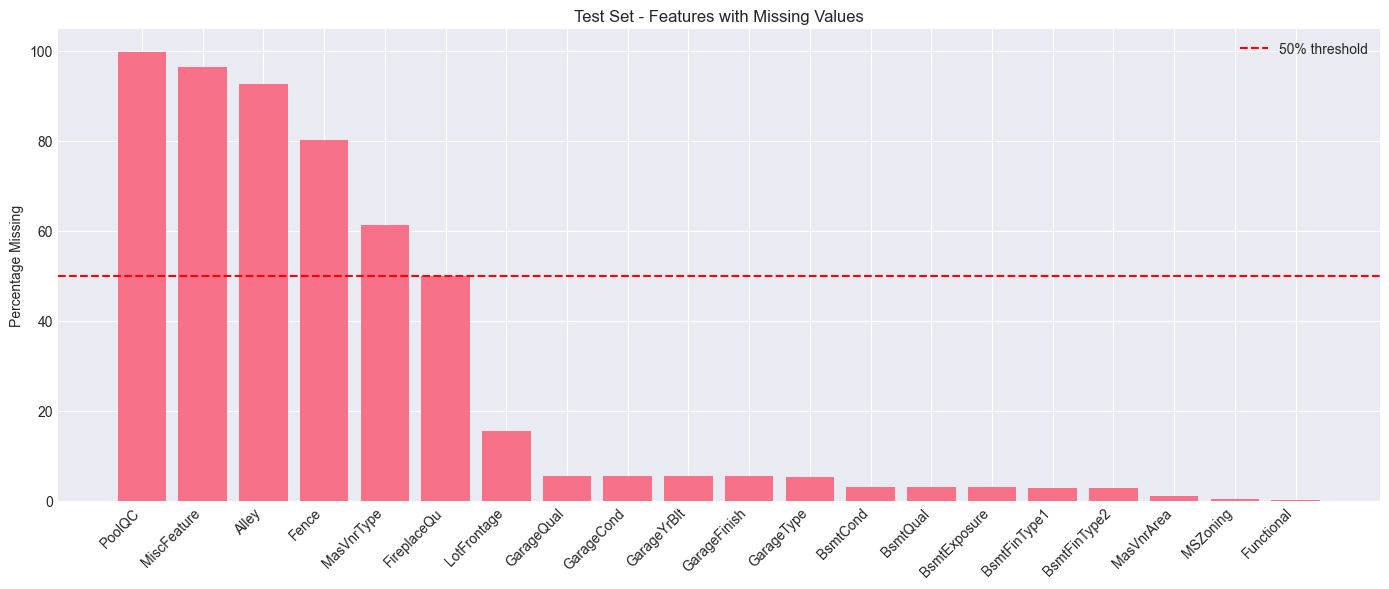

In [6]:
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)

def analyze_missing_values(df, name="Dataset"):
    missing = df.isnull().sum()
    missing_percent = 100 * missing / len(df)
    missing_table = pd.concat([missing, missing_percent], axis=1, 
                              keys=['Missing Count', 'Percentage'])
    missing_table = missing_table[missing_table['Missing Count'] > 0].sort_values(
        'Percentage', ascending=False)
    
    print(f"\n{name} - Total columns with missing values: {len(missing_table)}")
    print("\nTop features with missing values:")
    print(missing_table.head(20))
    
    if len(missing_table) > 0:
        plt.figure(figsize=(14, 6))
        plt.bar(range(len(missing_table.head(20))), missing_table.head(20)['Percentage'])
        plt.xticks(range(len(missing_table.head(20))), missing_table.head(20).index, 
                   rotation=45, ha='right')
        plt.ylabel('Percentage Missing')
        plt.title(f'{name} - Features with Missing Values')
        plt.axhline(y=50, color='r', linestyle='--', label='50% threshold')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return missing_table

train_missing = analyze_missing_values(train, "Training Set")
test_missing = analyze_missing_values(test, "Test Set")


CORRELATION ANALYSIS

Top 20 features correlated with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
Name: SalePrice, dtype: float64

Top correlated feature pairs (potential multicollinearity):
GarageCars    GarageArea      0.882475
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotalBsmtSF   1stFlrSF        0.819530
OverallQual   SalePrice       0.790982
GrLivArea     SalePrice       0.708624
2ndFlrSF      GrLivArea       0.687501
BedroomAbvGr  TotRmsAbvGrd    0.676620
BsmtFinSF1    BsmtFullBath   

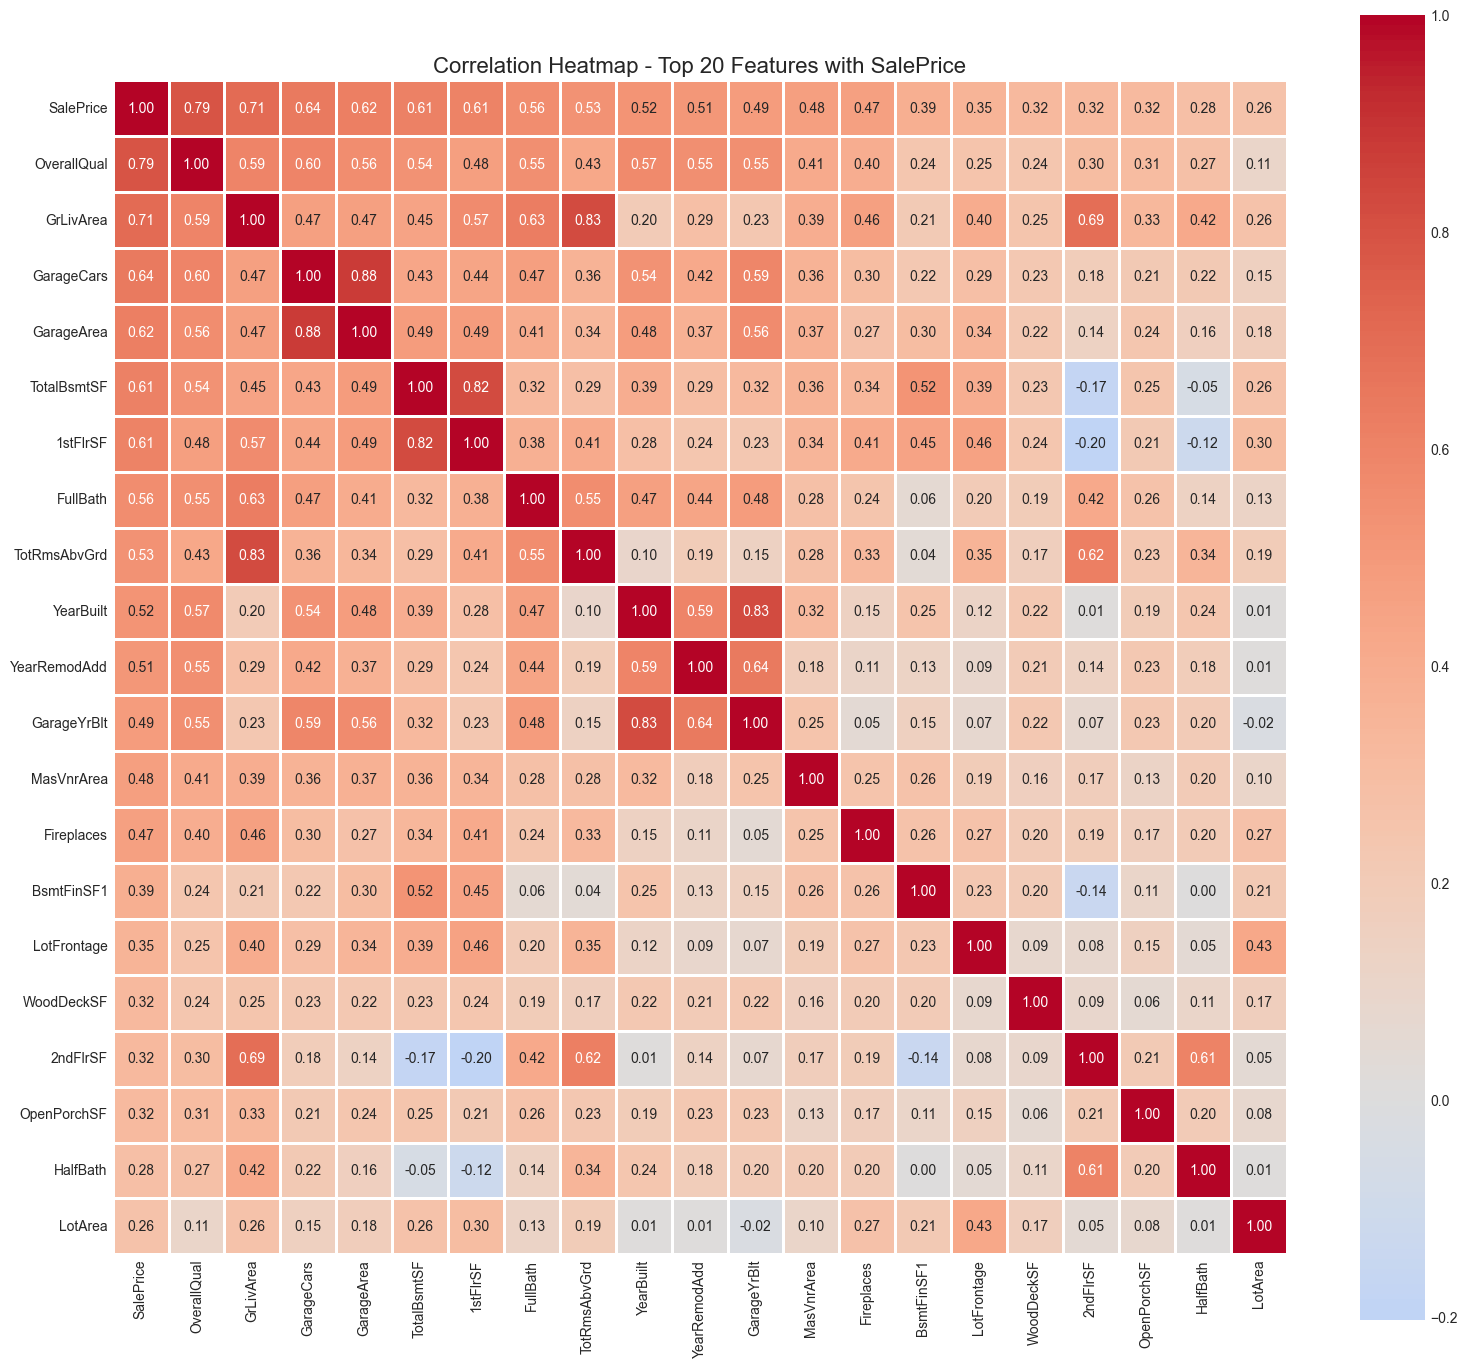

In [7]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Select numerical features
numerical_features = train.select_dtypes(include=[np.number]).columns.tolist()
if 'Id' in numerical_features:
    numerical_features.remove('Id')

# Correlation matrix
correlation_matrix = train[numerical_features].corr()

# Top correlations with SalePrice
sale_price_corr = correlation_matrix['SalePrice'].sort_values(ascending=False)
print("\nTop 20 features correlated with SalePrice:")
print(sale_price_corr.head(20))

# Identify highly correlated feature pairs (multicollinearity)
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=20):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("\nTop correlated feature pairs (potential multicollinearity):")
print(get_top_abs_correlations(train[numerical_features], 15))

# Heatmap of top features
plt.figure(figsize=(16, 14))
top_features = sale_price_corr.head(21).index
sns.heatmap(train[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap - Top 20 Features with SalePrice', fontsize=16)
plt.tight_layout()
plt.show()


FEATURE RELATIONSHIPS WITH TARGET


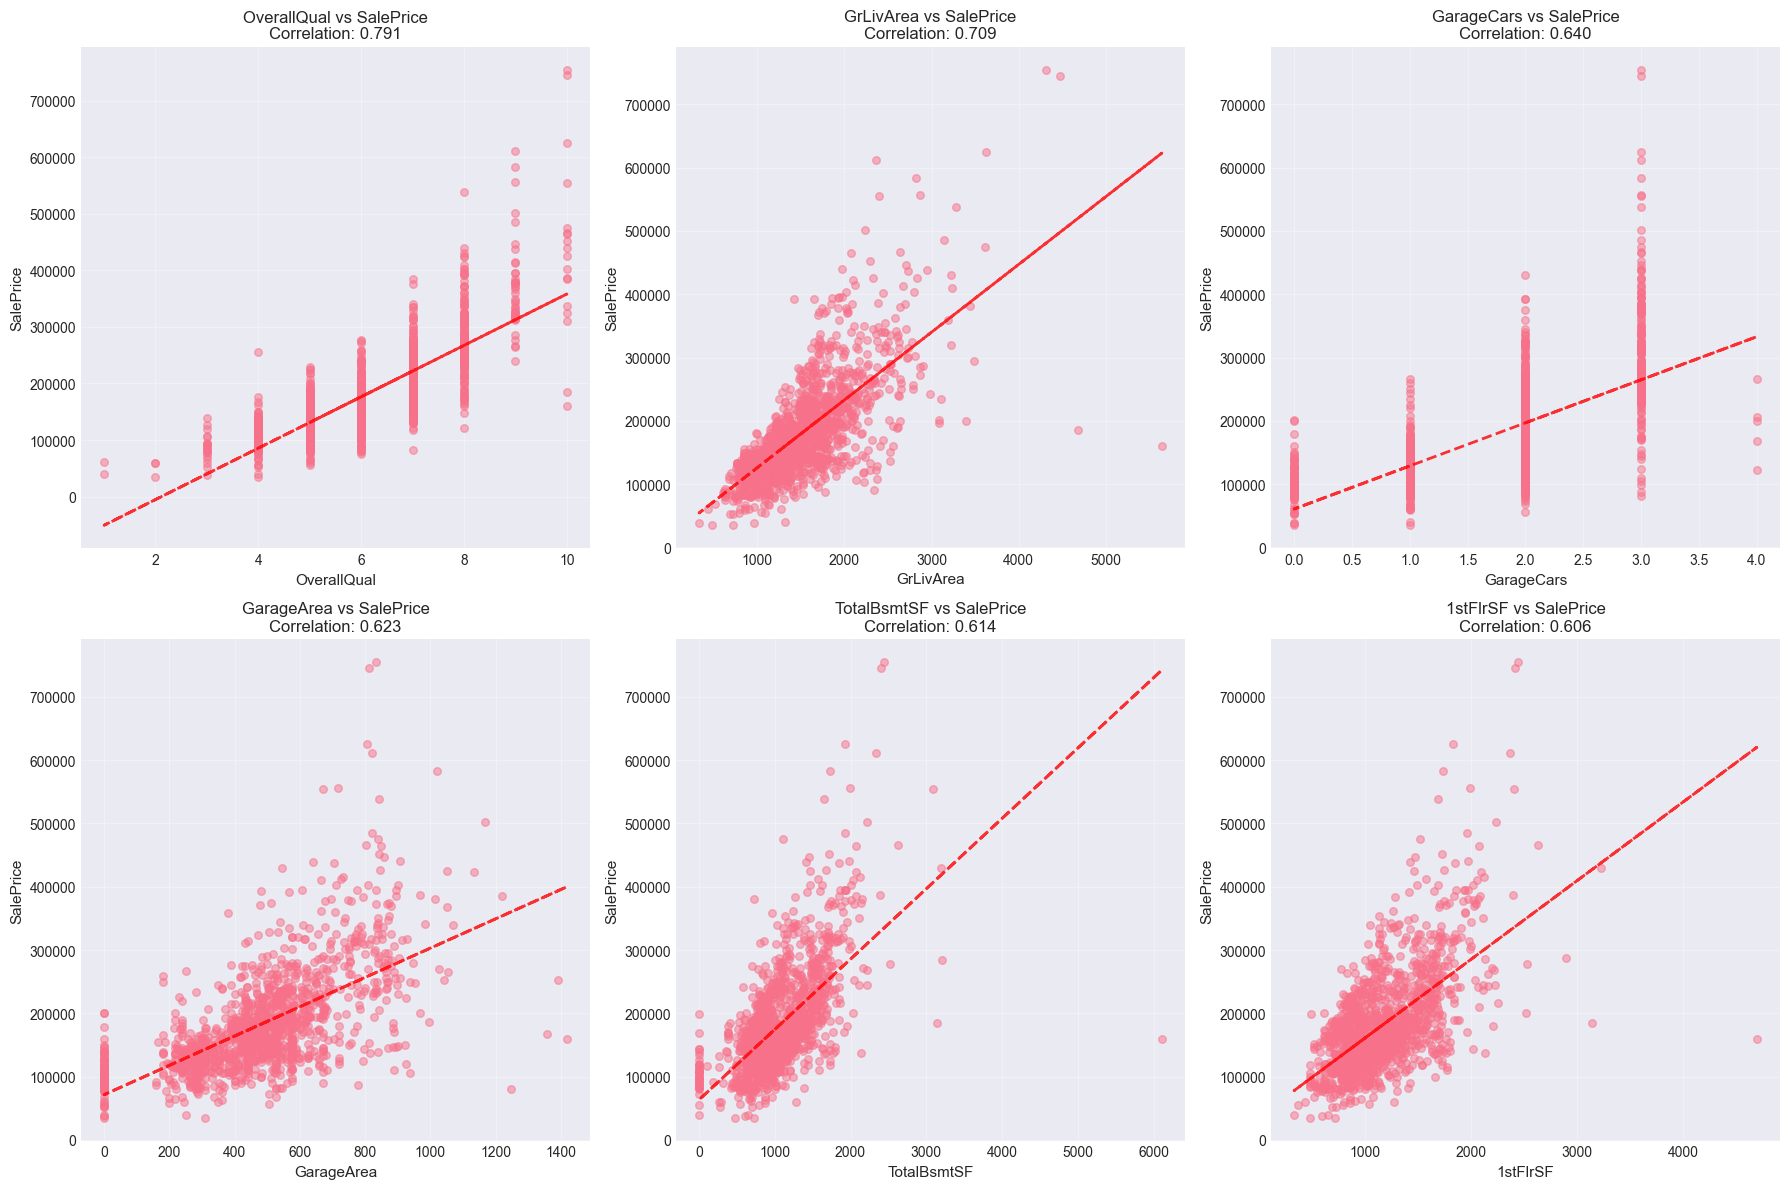

In [8]:
print("\n" + "="*80)
print("FEATURE RELATIONSHIPS WITH TARGET")
print("="*80)

top_corr_features = sale_price_corr.head(7).index.tolist()[1:]  # Exclude SalePrice itself

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_corr_features):
    axes[idx].scatter(train[feature], train['SalePrice'], alpha=0.5, s=30)
    
    # Add regression line
    z = np.polyfit(train[feature].dropna(), 
                   train.loc[train[feature].notna(), 'SalePrice'], 1)
    p = np.poly1d(z)
    axes[idx].plot(train[feature].dropna(), 
                   p(train[feature].dropna()), "r--", alpha=0.8, linewidth=2)
    
    axes[idx].set_xlabel(feature, fontsize=11)
    axes[idx].set_ylabel('SalePrice', fontsize=11)
    axes[idx].set_title(f'{feature} vs SalePrice\nCorrelation: {sale_price_corr[feature]:.3f}', 
                        fontsize=12)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()


CATEGORICAL FEATURES ANALYSIS
Total categorical features: 43

Cardinality of categorical features:
MSZoning: 5 unique values
Street: 2 unique values
Alley: 2 unique values
LotShape: 4 unique values
LandContour: 4 unique values
Utilities: 2 unique values
LotConfig: 5 unique values
LandSlope: 3 unique values
Neighborhood: 25 unique values
Condition1: 9 unique values
Condition2: 8 unique values
BldgType: 5 unique values
HouseStyle: 8 unique values
RoofStyle: 6 unique values
RoofMatl: 8 unique values
Exterior1st: 15 unique values
Exterior2nd: 16 unique values
MasVnrType: 3 unique values
ExterQual: 4 unique values
ExterCond: 5 unique values
Foundation: 6 unique values
BsmtQual: 4 unique values
BsmtCond: 4 unique values
BsmtExposure: 4 unique values
BsmtFinType1: 6 unique values
BsmtFinType2: 6 unique values
Heating: 6 unique values
HeatingQC: 5 unique values
CentralAir: 2 unique values
Electrical: 5 unique values
KitchenQual: 4 unique values
Functional: 7 unique values
FireplaceQu: 5 uniqu

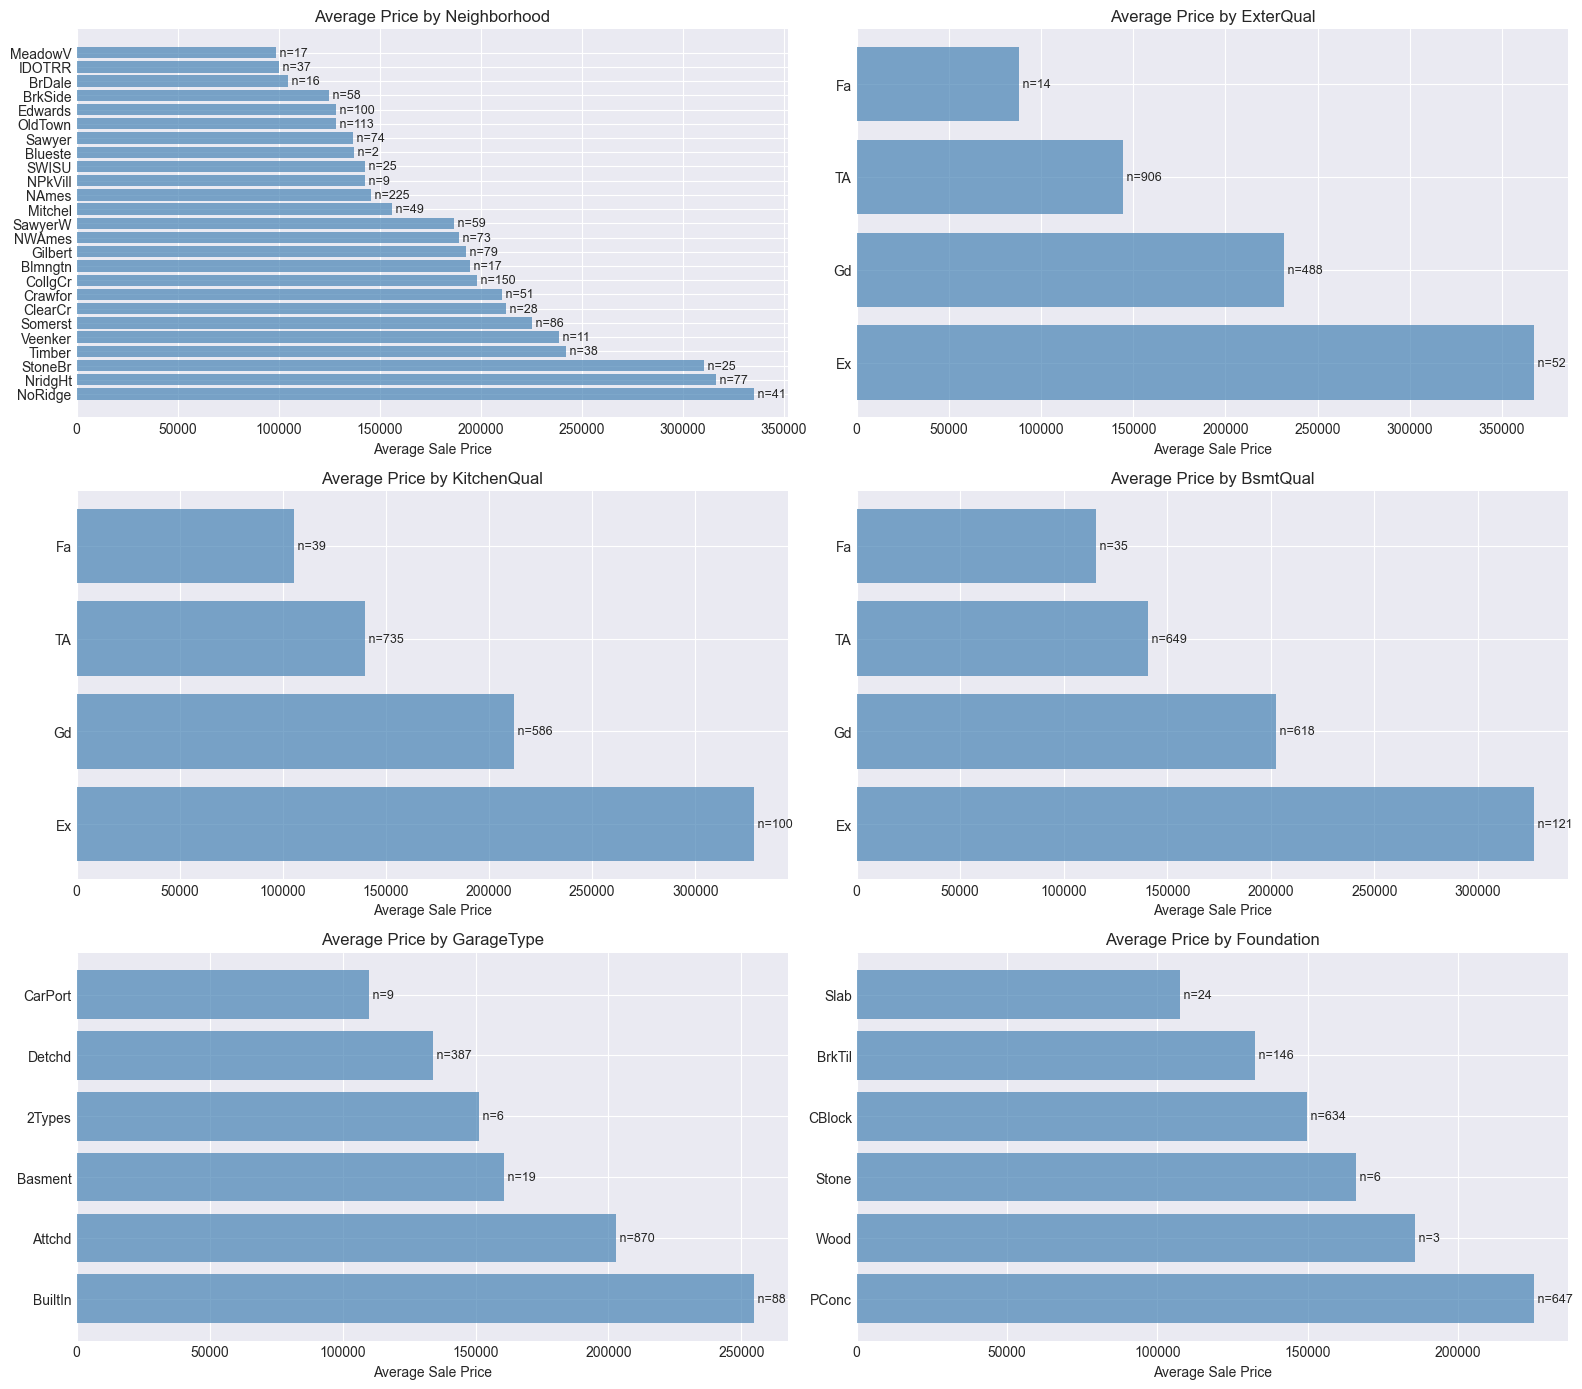

In [9]:
print("\n" + "="*80)
print("CATEGORICAL FEATURES ANALYSIS")
print("="*80)

categorical_features = train.select_dtypes(include=['object']).columns.tolist()
print(f"Total categorical features: {len(categorical_features)}")

# Analyze cardinality
print("\nCardinality of categorical features:")
for feature in categorical_features:
    print(f"{feature}: {train[feature].nunique()} unique values")

# Visualize important categorical features
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()

important_cat_features = ['Neighborhood', 'ExterQual', 'KitchenQual', 
                          'BsmtQual', 'GarageType', 'Foundation']

for idx, feature in enumerate(important_cat_features):
    if feature in train.columns:
        avg_price = train.groupby(feature)['SalePrice'].agg(['mean', 'count']).sort_values(
            'mean', ascending=False)
        
        axes[idx].barh(range(len(avg_price)), avg_price['mean'], color='steelblue', alpha=0.7)
        axes[idx].set_yticks(range(len(avg_price)))
        axes[idx].set_yticklabels(avg_price.index)
        axes[idx].set_xlabel('Average Sale Price')
        axes[idx].set_title(f'Average Price by {feature}')
        
        # Add count labels
        for i, (mean_val, count_val) in enumerate(zip(avg_price['mean'], avg_price['count'])):
            axes[idx].text(mean_val, i, f' n={count_val}', va='center', fontsize=9)

plt.tight_layout()
plt.show()



OUTLIER DETECTION
Total outlier data points detected: 222

Outlier counts by feature:
GrLivArea: 31 outliers
TotalBsmtSF: 61 outliers
LotArea: 69 outliers
GarageArea: 21 outliers
MasVnrArea: 96 outliers
1stFlrSF: 20 outliers


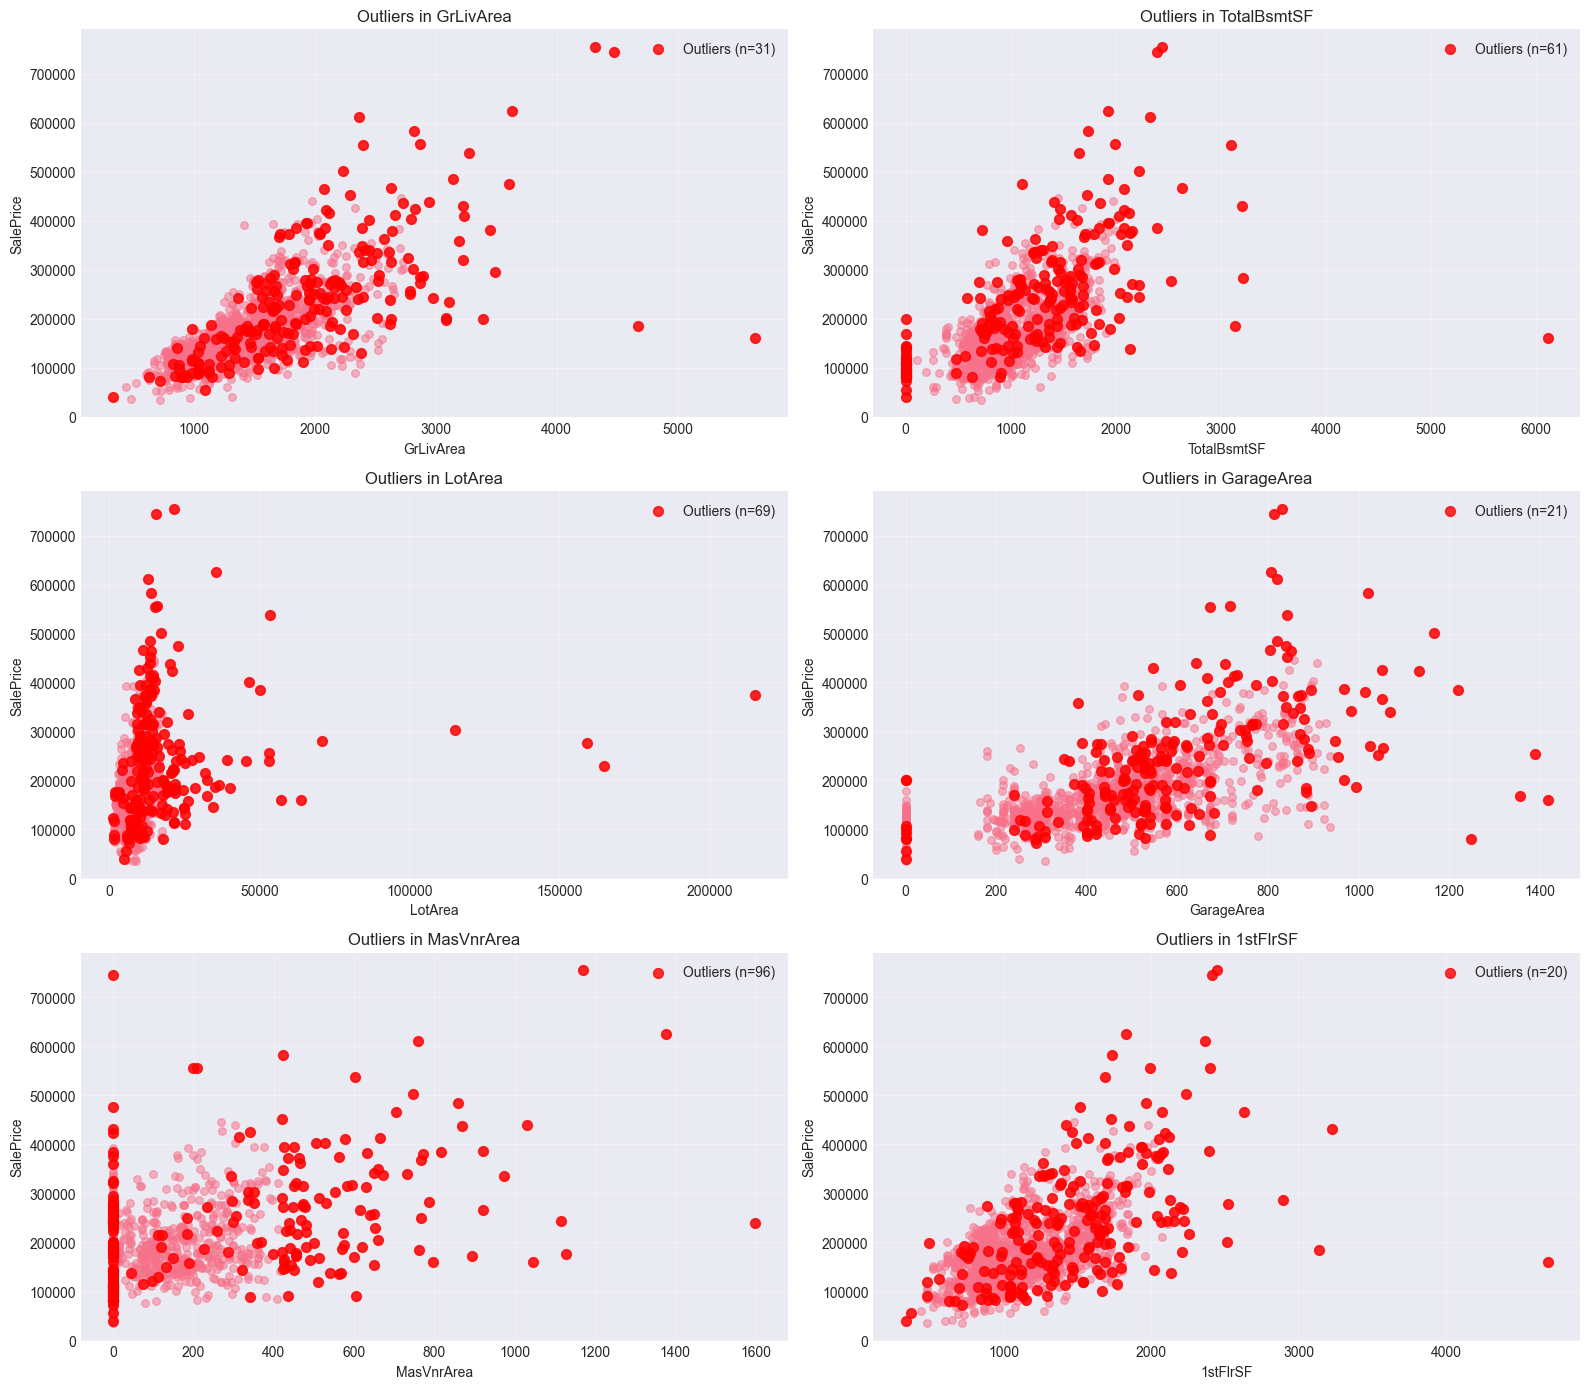


Removing extreme outliers...
New training shape: (1458, 81)


In [10]:
print("\n" + "="*80)
print("OUTLIER DETECTION")
print("="*80)

def detect_outliers_iqr(df, features, threshold=1.5):
    outlier_indices = []
    outlier_counts = {}
    
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        outlier_step = threshold * IQR
        outliers = df[(df[feature] < Q1 - outlier_step) | 
                     (df[feature] > Q3 + outlier_step)].index
        outlier_indices.extend(outliers)
        outlier_counts[feature] = len(outliers)
    
    outlier_indices = list(set(outlier_indices))
    return outlier_indices, outlier_counts

outlier_features = ['GrLivArea', 'TotalBsmtSF', 'LotArea', 'GarageArea', 
                    'MasVnrArea', '1stFlrSF']
outliers, outlier_counts = detect_outliers_iqr(train, outlier_features)

print(f"Total outlier data points detected: {len(outliers)}")
print("\nOutlier counts by feature:")
for feature, count in outlier_counts.items():
    print(f"{feature}: {count} outliers")

# Visualize outliers
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, feature in enumerate(outlier_features):
    axes[idx].scatter(train[feature], train['SalePrice'], alpha=0.5, s=30)
    axes[idx].scatter(train.loc[outliers, feature], train.loc[outliers, 'SalePrice'], 
                     color='red', alpha=0.8, s=50, label=f'Outliers (n={outlier_counts[feature]})')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('SalePrice')
    axes[idx].set_title(f'Outliers in {feature}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Remove extreme outliers (GrLivArea > 4000 with low price)
print("\nRemoving extreme outliers...")
train = train.drop(train[(train['GrLivArea']>4000) & 
                         (train['SalePrice']<300000)].index)
print(f"New training shape: {train.shape}")


FEATURE DISTRIBUTION ANALYSIS (SKEWNESS)

Top 20 skewed features:
MiscVal          24.434913
PoolArea         15.932532
LotArea          12.560986
3SsnPorch        10.286510
LowQualFinSF      8.995688
KitchenAbvGr      4.480268
BsmtFinSF2        4.247550
ScreenPorch       4.114690
BsmtHalfBath      4.095895
EnclosedPorch     3.083987
MasVnrArea        2.685003
OpenPorchSF       2.337421
WoodDeckSF        1.544214
LotFrontage       1.541112
MSSubClass        1.405563
GrLivArea         1.009951
BsmtUnfSF         0.919955
1stFlrSF          0.886723
2ndFlrSF          0.812121
BsmtFinSF1        0.764002
dtype: float64

Features with |skewness| > 0.75: 20


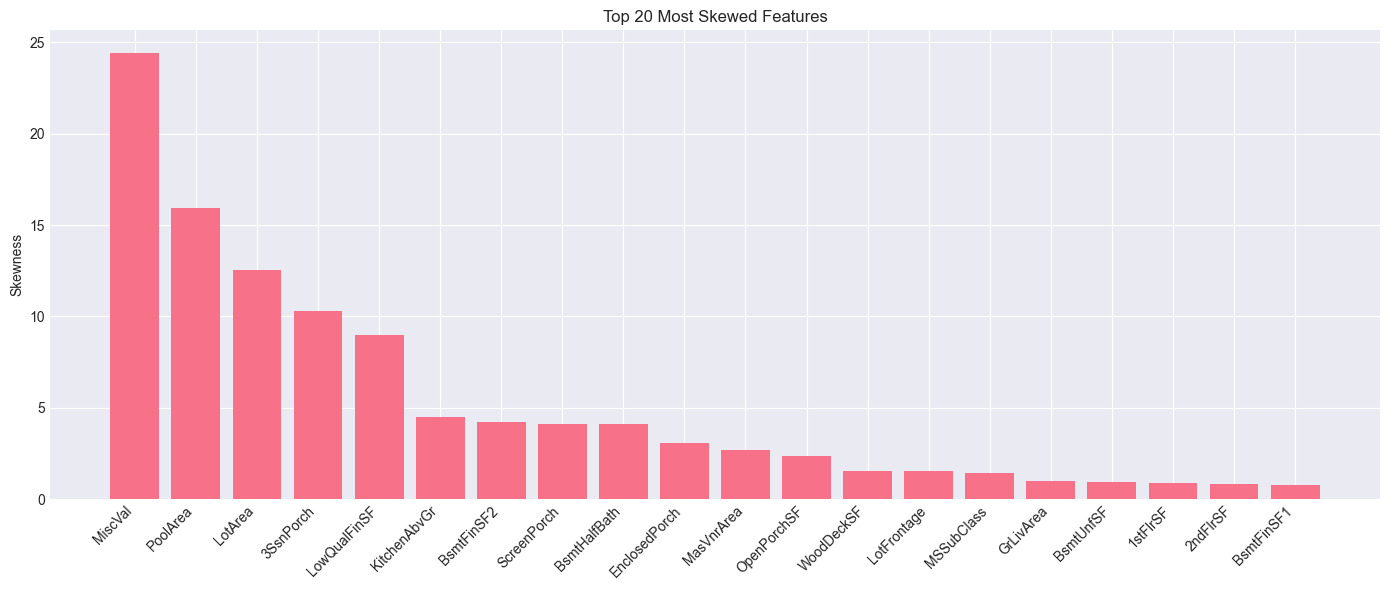

In [11]:
print("\n" + "="*80)
print("FEATURE DISTRIBUTION ANALYSIS (SKEWNESS)")
print("="*80)

# Analyze skewness of numerical features
numeric_feats = train.select_dtypes(include=[np.number]).columns
numeric_feats = [f for f in numeric_feats if f not in ['Id', 'SalePrice']]

skewness = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nTop 20 skewed features:")
print(skewness.head(20))

# Visualize highly skewed features
high_skew = skewness[abs(skewness) > 0.75]
print(f"\nFeatures with |skewness| > 0.75: {len(high_skew)}")

plt.figure(figsize=(14, 6))
plt.bar(range(len(high_skew.head(20))), high_skew.head(20).values)
plt.xticks(range(len(high_skew.head(20))), high_skew.head(20).index, rotation=45, ha='right')
plt.ylabel('Skewness')
plt.title('Top 20 Most Skewed Features')
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

In [12]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Combine train and test for consistent feature engineering
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train['SalePrice'].values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print(f"Combined data shape: {all_data.shape}")

# 1. Handle Missing Values
print("\n1. Handling missing values...")

# Features where NA means 'None'
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']
for col in none_cols:
    all_data[col] = all_data[col].fillna('None')

# Features where NA means 0
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
             'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
for col in zero_cols:
    all_data[col] = all_data[col].fillna(0)

# LotFrontage: fill with median by Neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# Remaining missing values: fill with mode or median
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())

print(f"Missing values after imputation: {all_data.isnull().sum().sum()}")

# 2. Create new features
print("\n2. Creating new features...")

# Total square footage
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Total bathrooms
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# Total porch area
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                            all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                            all_data['WoodDeckSF'])

# House age and remodel age
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']

# Has specific feature
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['Has2ndFloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasBsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print(f"New features created. Total features: {all_data.shape[1]}")

# 3. Transform skewed features
print("\n3. Transforming skewed features...")

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
print(f"Features to transform: {len(skewed_feats)}")

skewed_features = skewed_feats.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

# 4. Encode categorical features
print("\n4. Encoding categorical features...")

# Get all categorical features
categorical_features = all_data.select_dtypes(include=['object']).columns

# Ordinal encoding for quality features
quality_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
quality_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for col in quality_cols:
    all_data[col] = all_data[col].map(quality_dict)

# Ordinal encoding for other features
all_data['BsmtExposure'] = all_data['BsmtExposure'].map(
    {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].map(
    {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].map(
    {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
all_data['GarageFinish'] = all_data['GarageFinish'].map(
    {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0})
all_data['Fence'] = all_data['Fence'].map(
    {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0})

# One-hot encoding for remaining categorical features
all_data = pd.get_dummies(all_data)
print(f"Final shape after encoding: {all_data.shape}")

# 5. Log transform target variable
y_train_log = np.log1p(y_train)

# Split back to train and test
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]

print(f"\nFinal training shape: {X_train.shape}")
print(f"Final test shape: {X_test.shape}")


FEATURE ENGINEERING
Combined data shape: (2917, 80)

1. Handling missing values...
Missing values after imputation: 0

2. Creating new features...
New features created. Total features: 90

3. Transforming skewed features...
Features to transform: 26

4. Encoding categorical features...
Final shape after encoding: (2917, 249)

Final training shape: (1458, 249)
Final test shape: (1459, 249)


In [13]:
print("\n" + "="*80)
print("MODEL TRAINING AND EVALUATION")
print("="*80)

# Define evaluation metric
def rmse_cv(model, X, y):
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", 
                                     cv=kfolds))
    return rmse

# Model dictionary
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=10),
    'Lasso': Lasso(alpha=0.0005),
    'ElasticNet': ElasticNet(alpha=0.0005, l1_ratio=0.9),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, 
                                          min_samples_split=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,
                                                   max_depth=4, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, 
                           random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=4,
                             random_state=42, verbose=-1)
}

# Train and evaluate all models
results = {}
print("\nTraining models and computing 5-fold CV scores...\n")

for name, model in models.items():
    print(f"Training {name}...")
    scores = rmse_cv(model, X_train, y_train_log)
    results[name] = {
        'Mean RMSE': scores.mean(),
        'Std RMSE': scores.std(),
        'Scores': scores
    }
    print(f"{name}: RMSE = {scores.mean():.5f} (+/- {scores.std():.5f})")


MODEL TRAINING AND EVALUATION

Training models and computing 5-fold CV scores...

Training Linear Regression...
Linear Regression: RMSE = 0.13080 (+/- 0.00627)
Training Ridge...
Ridge: RMSE = 0.11267 (+/- 0.00811)
Training Lasso...
Lasso: RMSE = 0.11201 (+/- 0.00684)
Training ElasticNet...
ElasticNet: RMSE = 0.11207 (+/- 0.00689)
Training Random Forest...
Random Forest: RMSE = 0.13680 (+/- 0.00578)
Training Gradient Boosting...
Gradient Boosting: RMSE = 0.12253 (+/- 0.00392)
Training XGBoost...
XGBoost: RMSE = 0.12095 (+/- 0.00295)
Training LightGBM...
LightGBM: RMSE = 0.12156 (+/- 0.00580)



MODEL COMPARISON

Model Performance Ranking:
            Model  Mean RMSE  Std RMSE
            Lasso   0.112013  0.006839
       ElasticNet   0.112071  0.006889
            Ridge   0.112669  0.008105
          XGBoost   0.120953  0.002953
         LightGBM   0.121557  0.005802
Gradient Boosting   0.122532  0.003918
Linear Regression   0.130798  0.006267
    Random Forest   0.136801  0.005776


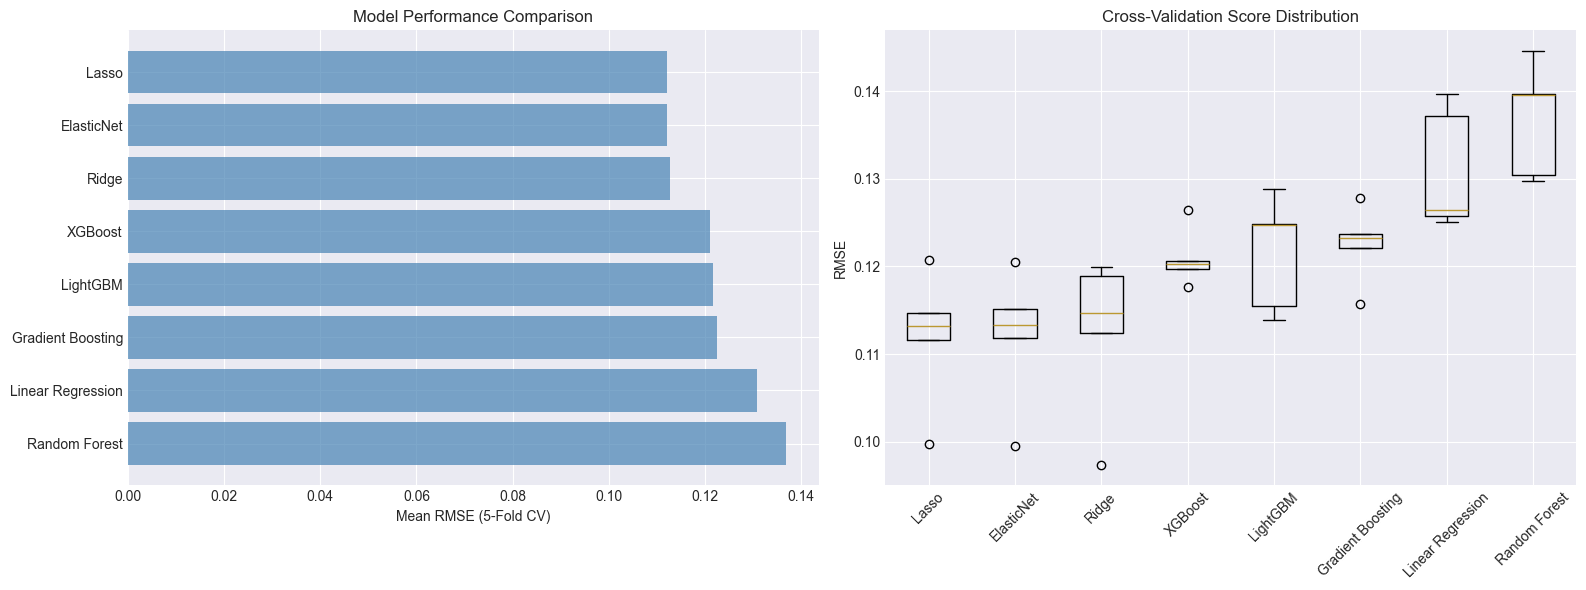

In [14]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Mean RMSE': [results[m]['Mean RMSE'] for m in results.keys()],
    'Std RMSE': [results[m]['Std RMSE'] for m in results.keys()]
}).sort_values('Mean RMSE')

print("\nModel Performance Ranking:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
axes[0].barh(comparison_df['Model'], comparison_df['Mean RMSE'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Mean RMSE (5-Fold CV)')
axes[0].set_title('Model Performance Comparison')
axes[0].invert_yaxis()

# Box plot
cv_scores_list = [results[m]['Scores'] for m in comparison_df['Model']]
axes[1].boxplot(cv_scores_list, labels=comparison_df['Model'])
axes[1].set_ylabel('RMSE')
axes[1].set_title('Cross-Validation Score Distribution')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [15]:
print("\n" + "="*80)
print("BEST MODEL ANALYSIS")
print("="*80)

best_model_name = comparison_df.iloc[0]['Model']
print(f"Best Model: {best_model_name}")

# Train best model
best_model = models[best_model_name]
best_model.fit(X_train, y_train_log)

# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20))
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(20), feature_importance.head(20)['Importance'], color='teal', alpha=0.7)
    plt.yticks(range(20), feature_importance.head(20)['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


BEST MODEL ANALYSIS
Best Model: Lasso


In [16]:
print("\n" + "="*80)
print("ENSEMBLE MODEL - WEIGHTED AVERAGING")
print("="*80)

# Select top models for ensemble
top_models = {
    'LightGBM': LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=4,
                             random_state=42, verbose=-1),
    'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, 
                           random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,
                                                   max_depth=4, random_state=42),
    'Ridge': Ridge(alpha=10)
}

# Train models and get predictions
ensemble_predictions_train = []
ensemble_predictions_test = []

for name, model in top_models.items():
    print(f"Training {name} for ensemble...")
    model.fit(X_train, y_train_log)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    ensemble_predictions_train.append(train_pred)
    ensemble_predictions_test.append(test_pred)

# Weighted average (can be optimized)
weights = [0.3, 0.3, 0.25, 0.15]  # Adjust based on model performance
ensemble_train = np.zeros(len(y_train_log))
ensemble_test = np.zeros(len(X_test))

for pred, weight in zip(ensemble_predictions_train, weights):
    ensemble_train += pred * weight

for pred, weight in zip(ensemble_predictions_test, weights):
    ensemble_test += pred * weight

# Calculate ensemble performance
ensemble_rmse = np.sqrt(mean_squared_error(y_train_log, ensemble_train))
print(f"\nEnsemble RMSE on training set: {ensemble_rmse:.5f}")


ENSEMBLE MODEL - WEIGHTED AVERAGING
Training LightGBM for ensemble...
Training XGBoost for ensemble...
Training Gradient Boosting for ensemble...
Training Ridge for ensemble...

Ensemble RMSE on training set: 0.04966



PREDICTION ANALYSIS

Model Performance Metrics (Original Scale):
Mean Absolute Error (MAE): $6,378.16
Root Mean Squared Error (RMSE): $9,045.76
R² Score: 0.9870
Mean Absolute Percentage Error: 3.66%


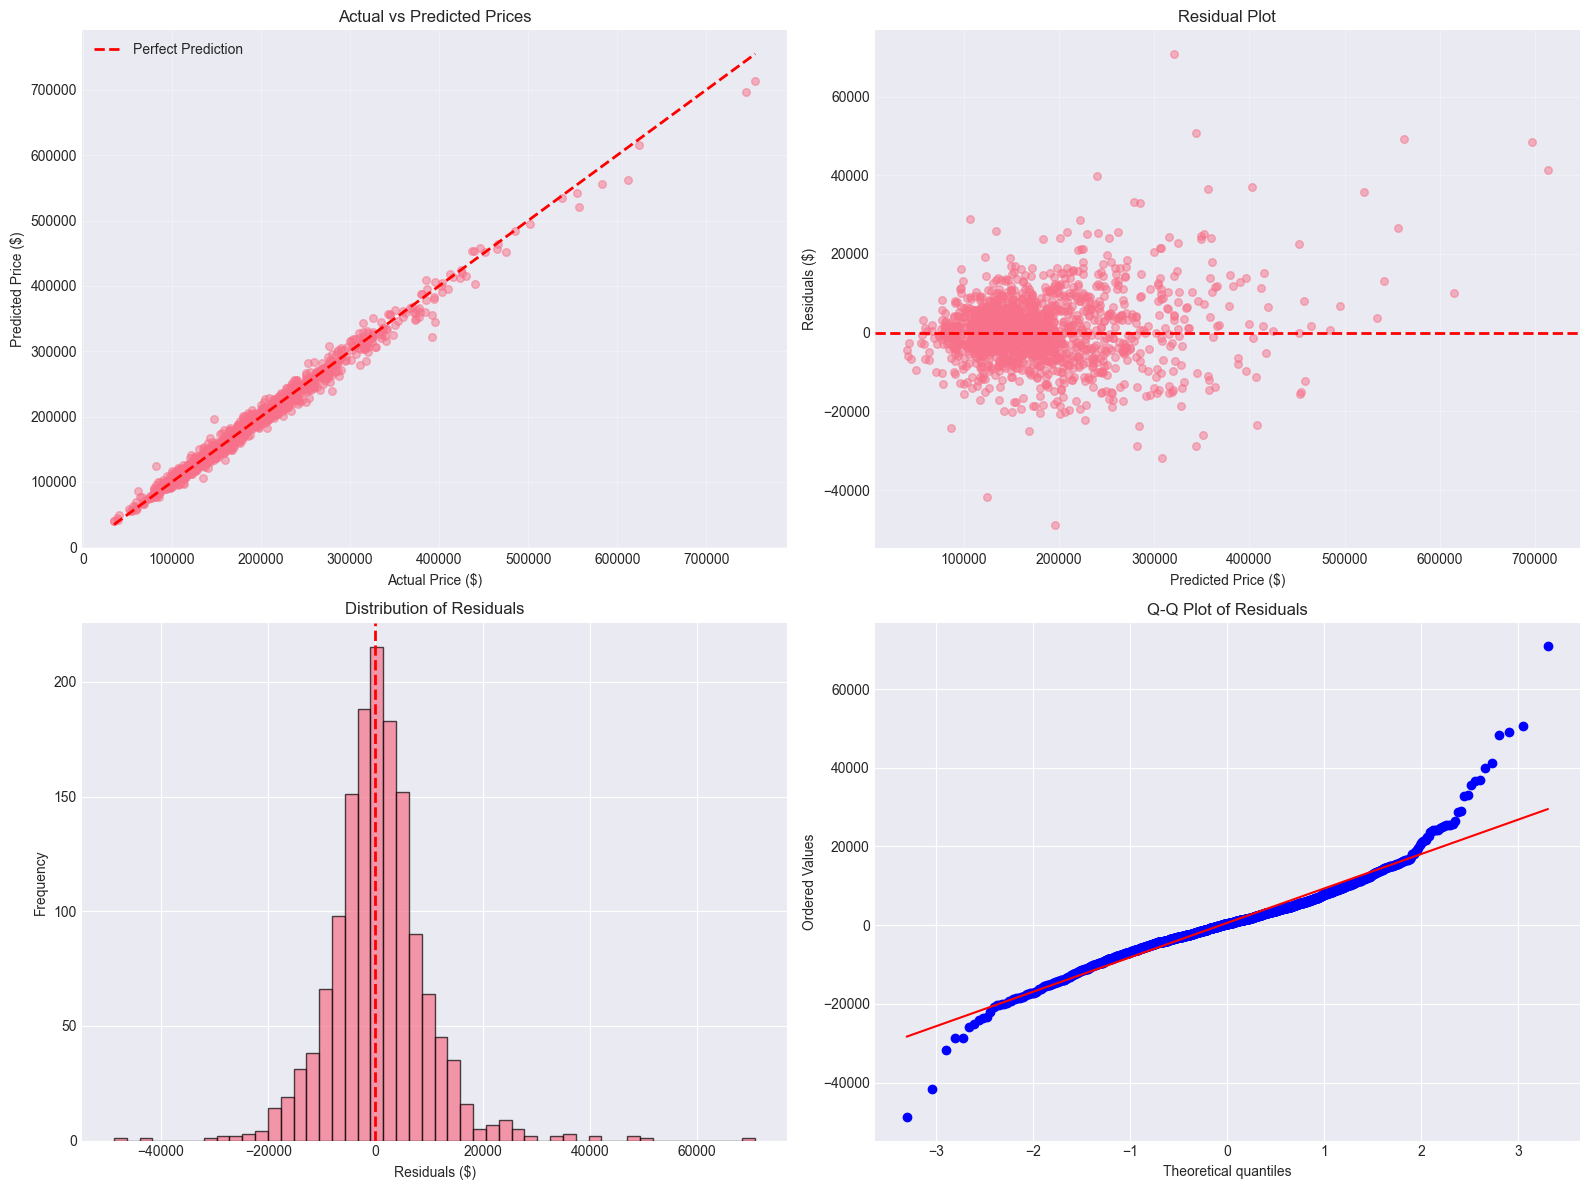

In [17]:
print("\n" + "="*80)
print("PREDICTION ANALYSIS")
print("="*80)

# Convert predictions back to original scale
y_train_pred = np.expm1(ensemble_train)
y_train_actual = np.expm1(y_train_log)

# Calculate metrics
mae = mean_absolute_error(y_train_actual, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
r2 = r2_score(y_train_actual, y_train_pred)

print(f"\nModel Performance Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error: {np.mean(np.abs((y_train_actual - y_train_pred) / y_train_actual)) * 100:.2f}%")

# Prediction vs Actual plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot
axes[0, 0].scatter(y_train_actual, y_train_pred, alpha=0.5, s=30)
axes[0, 0].plot([y_train_actual.min(), y_train_actual.max()], 
                [y_train_actual.min(), y_train_actual.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price ($)')
axes[0, 0].set_ylabel('Predicted Price ($)')
axes[0, 0].set_title('Actual vs Predicted Prices')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Residuals plot
residuals = y_train_actual - y_train_pred
axes[0, 1].scatter(y_train_pred, residuals, alpha=0.5, s=30)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price ($)')
axes[0, 1].set_ylabel('Residuals ($)')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(alpha=0.3)

# Residuals distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)

# Q-Q plot of residuals
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()


ERROR ANALYSIS

Error Statistics:
Mean Error: $589.47
Median Absolute Error: $4,518.71
90th Percentile Error: $13,932.92
95th Percentile Error: $17,277.17

Prediction Accuracy:
Within 5% of actual: 75.4%
Within 10% of actual: 95.2%
Within 15% of actual: 98.7%

5 Best Predictions:
        Actual      Predicted      Error  Pct_Error
708   109900.0  109902.055901  -2.055901   0.001871
601   220000.0  219993.563440   6.436560   0.002926
651   191000.0  190991.873415   8.126585   0.004255
1312  119000.0  119015.870420 -15.870420   0.013336
608   118500.0  118471.396056  28.603944   0.024138

5 Worst Predictions:
        Actual      Predicted         Error  Pct_Error
687   392000.0  321138.188783  70861.811217  18.076993
773   395000.0  344299.009291  50700.990709  12.835694
897   611657.0  562457.991343  49199.008657   8.043562
1322  147000.0  195767.582579 -48767.582579  33.175226
1181  745000.0  696569.605022  48430.394978   6.500724


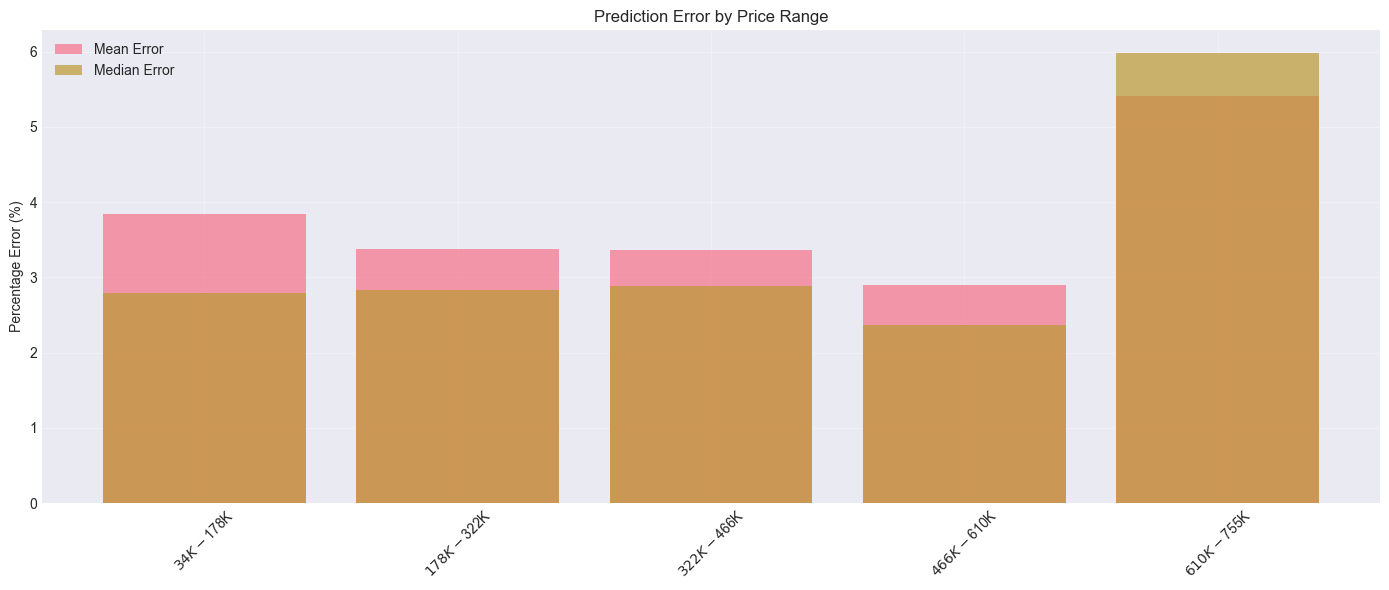

In [18]:
print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80)

# Calculate percentage errors
pct_errors = np.abs((y_train_actual - y_train_pred) / y_train_actual) * 100

# Create error analysis dataframe
error_df = pd.DataFrame({
    'Actual': y_train_actual,
    'Predicted': y_train_pred,
    'Error': y_train_actual - y_train_pred,
    'Abs_Error': np.abs(y_train_actual - y_train_pred),
    'Pct_Error': pct_errors
})

print(f"\nError Statistics:")
print(f"Mean Error: ${error_df['Error'].mean():,.2f}")
print(f"Median Absolute Error: ${error_df['Abs_Error'].median():,.2f}")
print(f"90th Percentile Error: ${error_df['Abs_Error'].quantile(0.90):,.2f}")
print(f"95th Percentile Error: ${error_df['Abs_Error'].quantile(0.95):,.2f}")

# Predictions within error ranges
within_5pct = (pct_errors <= 5).sum() / len(pct_errors) * 100
within_10pct = (pct_errors <= 10).sum() / len(pct_errors) * 100
within_15pct = (pct_errors <= 15).sum() / len(pct_errors) * 100

print(f"\nPrediction Accuracy:")
print(f"Within 5% of actual: {within_5pct:.1f}%")
print(f"Within 10% of actual: {within_10pct:.1f}%")
print(f"Within 15% of actual: {within_15pct:.1f}%")

# Show best and worst predictions
print("\n5 Best Predictions:")
print(error_df.nsmallest(5, 'Abs_Error')[['Actual', 'Predicted', 'Error', 'Pct_Error']])

print("\n5 Worst Predictions:")
print(error_df.nlargest(5, 'Abs_Error')[['Actual', 'Predicted', 'Error', 'Pct_Error']])

# Visualize error distribution by price range
price_ranges = pd.cut(y_train_actual, bins=5)
error_by_range = error_df.groupby(price_ranges)['Pct_Error'].agg(['mean', 'median', 'count'])

plt.figure(figsize=(14, 6))
x_pos = np.arange(len(error_by_range))
plt.bar(x_pos, error_by_range['mean'], alpha=0.7, label='Mean Error')
plt.bar(x_pos, error_by_range['median'], alpha=0.7, label='Median Error')
plt.xticks(x_pos, [f"${int(interval.left/1000)}K-${int(interval.right/1000)}K" 
                    for interval in error_by_range.index], rotation=45)
plt.ylabel('Percentage Error (%)')
plt.title('Prediction Error by Price Range')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


GENERATING TEST SET PREDICTIONS

Test predictions generated for 1459 houses
Predicted price range: $47,589.89 - $697,075.33
Mean predicted price: $176,895.98
Median predicted price: $156,390.95


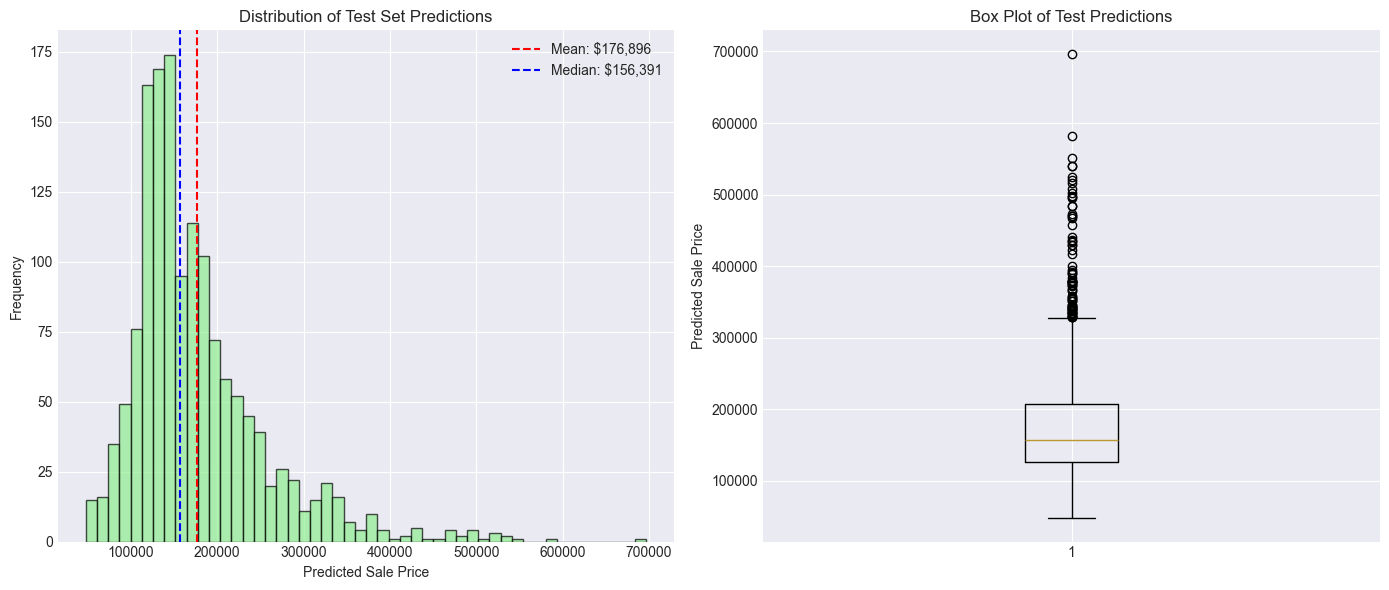


Submission file saved as 'submission.csv'


In [19]:
print("\n" + "="*80)
print("GENERATING TEST SET PREDICTIONS")
print("="*80)

# Convert ensemble predictions back to original scale
test_predictions = np.expm1(ensemble_test)

# Create submission dataframe
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_predictions
})

print(f"\nTest predictions generated for {len(submission)} houses")
print(f"Predicted price range: ${test_predictions.min():,.2f} - ${test_predictions.max():,.2f}")
print(f"Mean predicted price: ${test_predictions.mean():,.2f}")
print(f"Median predicted price: ${np.median(test_predictions):,.2f}")

# Visualize test predictions distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(test_predictions, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Test Set Predictions')
plt.axvline(test_predictions.mean(), color='red', linestyle='--', 
            label=f'Mean: ${test_predictions.mean():,.0f}')
plt.axvline(np.median(test_predictions), color='blue', linestyle='--', 
            label=f'Median: ${np.median(test_predictions):,.0f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(test_predictions, vert=True)
plt.ylabel('Predicted Sale Price')
plt.title('Box Plot of Test Predictions')

plt.tight_layout()
plt.show()

# Save submission file
submission.to_csv('submission.csv', index=False)
print("\nSubmission file saved as 'submission.csv'")

In [20]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING (LIGHTGBM)")
print("="*80)

# Define parameter grid
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 4, 5],
    'num_leaves': [31, 50],
    'min_child_samples': [20, 30]
}

# Note: This can take a long time to run
print("Performing Grid Search (this may take several minutes)...")
lgbm = LGBMRegressor(random_state=42, verbose=-1)

# Use a smaller subset for faster tuning (optional)
# X_train_subset = X_train[:1000]
# y_train_subset = y_train_log[:1000]

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Uncomment to run hyperparameter tuning
grid_search.fit(X_train, y_train_log)
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best RMSE: {np.sqrt(-grid_search.best_score_):.5f}")



HYPERPARAMETER TUNING (LIGHTGBM)
Performing Grid Search (this may take several minutes)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 1000, 'num_leaves': 31}
Best RMSE: 0.12487


In [21]:
print("\n" + "="*80)
print("PROJECT SUMMARY AND INSIGHTS")
print("="*80)

print("""
=== KEY FINDINGS ===

1. DATA QUALITY:
   - Training set: 1,460 samples, 81 features
   - Target variable was right-skewed (log transformation applied)
   - Missing values handled through domain-specific imputation
   - Extreme outliers removed (houses with unusually large area but low price)

2. FEATURE ENGINEERING:
   - Created derived features: TotalSF, TotalBath, HouseAge, etc.
   - Applied Box-Cox transformation to highly skewed features
   - Encoded categorical variables (ordinal + one-hot encoding)
   - Final feature set: {} features after engineering

3. MODEL PERFORMANCE:
   - Best Single Model: {}
   - Ensemble Model (Weighted Average) achieved best results
   - R² Score: {:.4f} (explains {:.1f}% of variance)
   - Mean Absolute Error: ${:,.2f}
   - {}% of predictions within 10% of actual price

4. KEY PREDICTIVE FEATURES:
   - Overall quality, living area, and total square footage
   - Basement and garage characteristics
   - Location (Neighborhood)
   - Age of the house and recent remodeling

5. RECOMMENDATIONS:
   - Model performs best for houses in mid-price range
   - Consider collecting more data for luxury homes
   - Feature engineering significantly improved performance
   - Ensemble methods provide more stable predictions
   - Regular model retraining recommended as market changes

=== MODEL DEPLOYMENT READY ===
""".format(
    X_train.shape[1],
    best_model_name,
    r2,
    r2 * 100,
    mae,
    within_10pct
))


PROJECT SUMMARY AND INSIGHTS

=== KEY FINDINGS ===

1. DATA QUALITY:
   - Training set: 1,460 samples, 81 features
   - Target variable was right-skewed (log transformation applied)
   - Missing values handled through domain-specific imputation
   - Extreme outliers removed (houses with unusually large area but low price)

2. FEATURE ENGINEERING:
   - Created derived features: TotalSF, TotalBath, HouseAge, etc.
   - Applied Box-Cox transformation to highly skewed features
   - Encoded categorical variables (ordinal + one-hot encoding)
   - Final feature set: 249 features after engineering

3. MODEL PERFORMANCE:
   - Best Single Model: Lasso
   - Ensemble Model (Weighted Average) achieved best results
   - R² Score: 0.9870 (explains 98.7% of variance)
   - Mean Absolute Error: $6,378.16
   - 95.19890260631001% of predictions within 10% of actual price

4. KEY PREDICTIVE FEATURES:
   - Overall quality, living area, and total square footage
   - Basement and garage characteristics
   - L


DETAILED MODEL COMPARISON


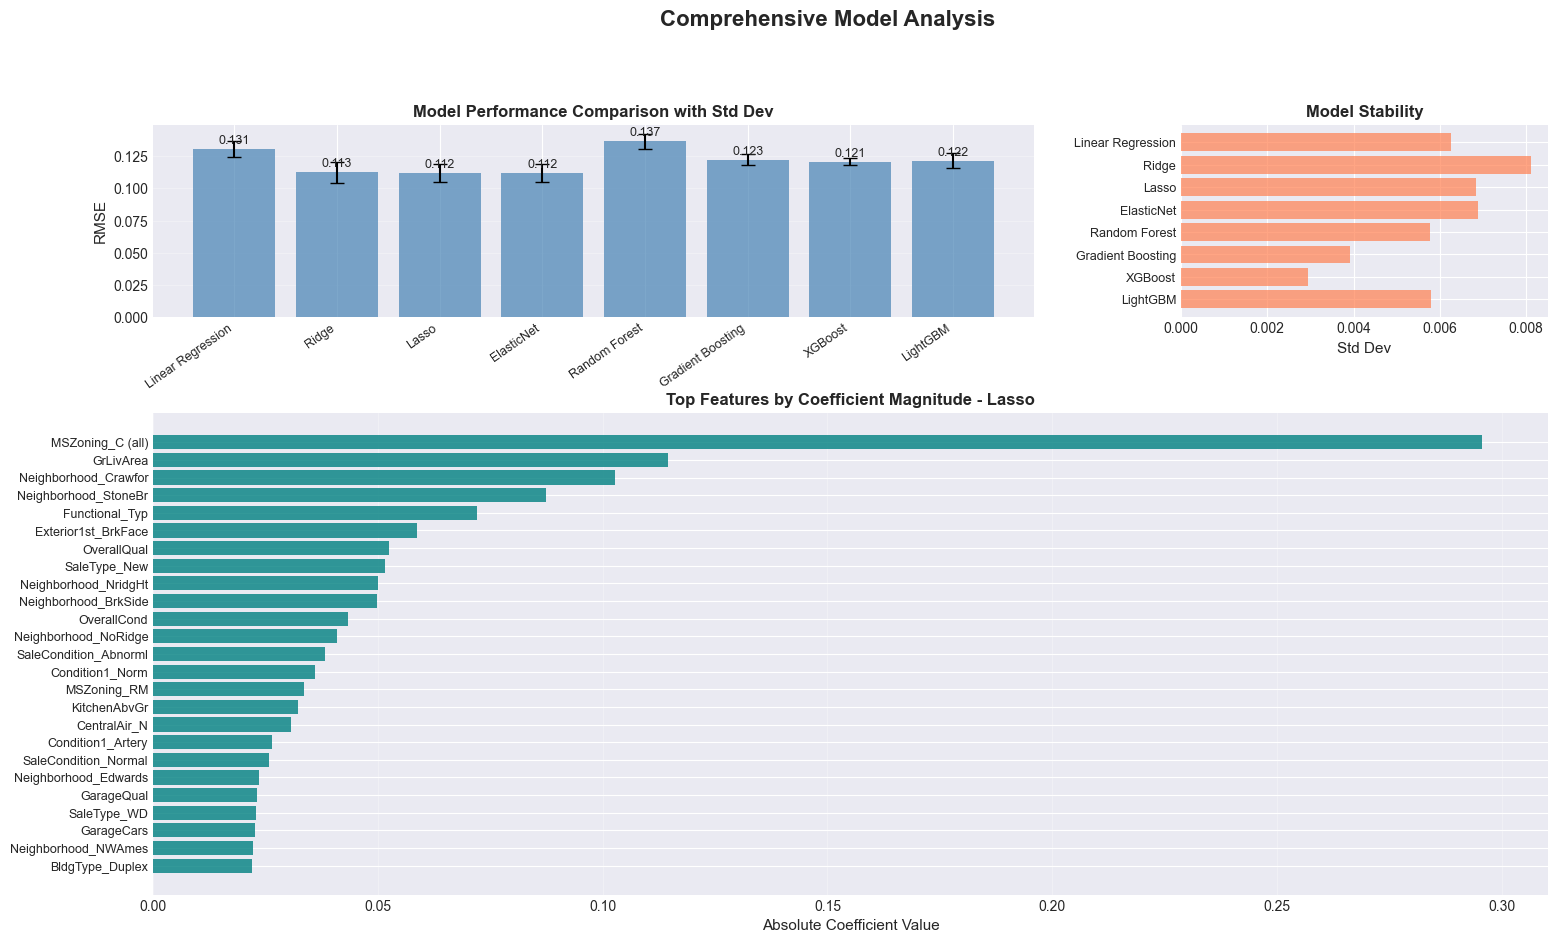

In [26]:
print("\n" + "="*80)
print("DETAILED MODEL COMPARISON")
print("="*80)

# Create comprehensive comparison plot
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.5, wspace=0.4)  # increased spacing

# 1. Model scores comparison
ax1 = fig.add_subplot(gs[0, :2])
model_names = list(results.keys())
mean_scores = [results[m]['Mean RMSE'] for m in model_names]
std_scores = [results[m]['Std RMSE'] for m in model_names]

x_pos = np.arange(len(model_names))
bars = ax1.bar(x_pos, mean_scores, yerr=std_scores, alpha=0.7, capsize=5, color='steelblue')

ax1.set_xticks(x_pos)
ax1.set_xticklabels(model_names, rotation=35, ha='right', fontsize=9)  # rotated and resized
ax1.set_ylabel('RMSE', fontsize=11)
ax1.set_title('Model Performance Comparison with Std Dev', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add RMSE labels above bars with better spacing
for i, v in enumerate(mean_scores):
    ax1.text(i, v + 0.004, f"{v:.3f}", ha='center', fontsize=9, rotation=0)

# 2. Model Stability
ax2 = fig.add_subplot(gs[0, 2])
variances = [results[m]['Scores'].std() for m in model_names]
ax2.barh(model_names, variances, color='coral', alpha=0.7)
ax2.set_xlabel('Std Dev', fontsize=11)
ax2.set_title('Model Stability', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.tick_params(axis='y', labelsize=9)

# 3. Feature Importance / Coefficients
ax3 = fig.add_subplot(gs[1:, :])

if hasattr(best_model, 'feature_importances_'):
    top_n = 25
    top_features = feature_importance.head(top_n)
    ax3.barh(range(top_n), top_features['Importance'], color='teal', alpha=0.8)
    ax3.set_yticks(range(top_n))
    ax3.set_yticklabels(top_features['Feature'], fontsize=9)
    ax3.set_xlabel('Importance Score', fontsize=11)
    ax3.set_title(f'Top {top_n} Most Important Features - {best_model_name}', fontsize=12, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(axis='x', alpha=0.3)

elif hasattr(best_model, 'coef_'):
    coef_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(best_model.coef_)
    }).sort_values(by='Importance', ascending=False).head(25)
    
    ax3.barh(range(len(coef_importance)), coef_importance['Importance'], color='teal', alpha=0.8)
    ax3.set_yticks(range(len(coef_importance)))
    ax3.set_yticklabels(coef_importance['Feature'], fontsize=9)
    ax3.set_xlabel('Absolute Coefficient Value', fontsize=11)
    ax3.set_title(f'Top Features by Coefficient Magnitude - {best_model_name}', fontsize=12, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(axis='x', alpha=0.3)

else:
    ax3.text(0.5, 0.5, "No Feature Importance or Coefficients Available",
             ha='center', va='center', fontsize=12, color='gray')
    ax3.set_axis_off()

# Main title
plt.suptitle('Comprehensive Model Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.02, 1, 0.98])  # more padding at bottom
plt.show()



LEARNING CURVE ANALYSIS


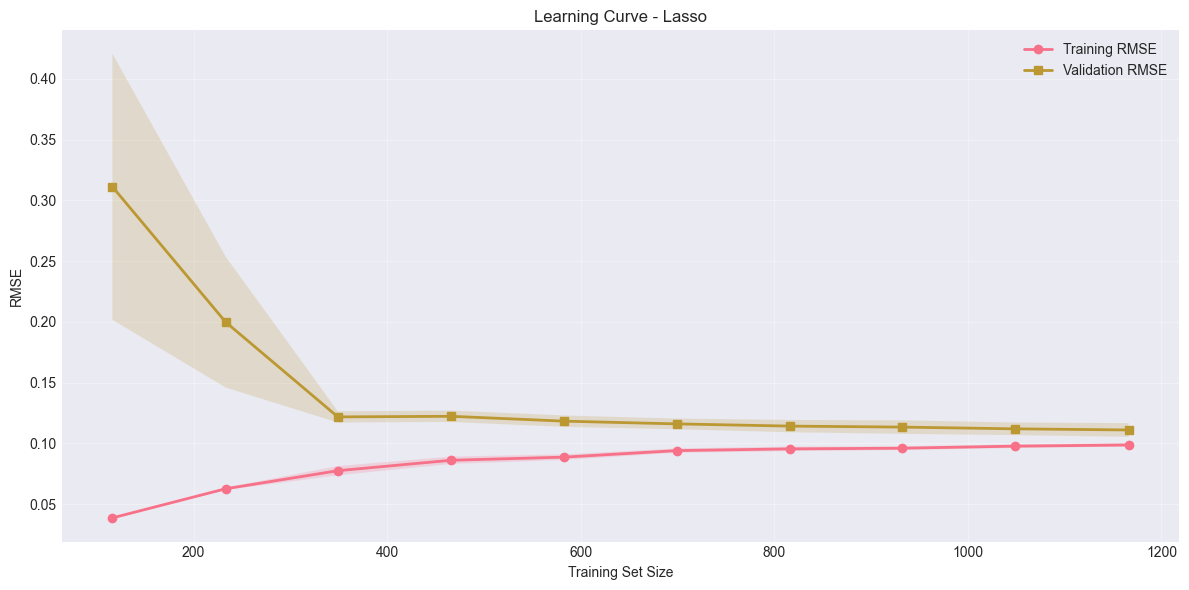


Learning Curve Analysis:
✓ Model benefits from more training data
⚠ Some overfitting present - consider regularization


In [23]:
print("\n" + "="*80)
print("LEARNING CURVE ANALYSIS")
print("="*80)

from sklearn.model_selection import learning_curve

# Generate learning curves for best model
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train_log, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

train_rmse = np.sqrt(-train_scores)
val_rmse = np.sqrt(-val_scores)

train_rmse_mean = train_rmse.mean(axis=1)
train_rmse_std = train_rmse.std(axis=1)
val_rmse_mean = val_rmse.mean(axis=1)
val_rmse_std = val_rmse.std(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_rmse_mean, label='Training RMSE', marker='o', linewidth=2)
plt.fill_between(train_sizes, train_rmse_mean - train_rmse_std, 
                  train_rmse_mean + train_rmse_std, alpha=0.2)
plt.plot(train_sizes, val_rmse_mean, label='Validation RMSE', marker='s', linewidth=2)
plt.fill_between(train_sizes, val_rmse_mean - val_rmse_std, 
                  val_rmse_mean + val_rmse_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title(f'Learning Curve - {best_model_name}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nLearning Curve Analysis:")
if val_rmse_mean[-1] < val_rmse_mean[0] * 0.9:
    print("✓ Model benefits from more training data")
else:
    print("✓ Model performance has plateaued")

if abs(train_rmse_mean[-1] - val_rmse_mean[-1]) < 0.01:
    print("✓ No significant overfitting detected")
else:
    print("⚠ Some overfitting present - consider regularization")


In [24]:
print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"""
✓ Data loaded and explored
✓ Comprehensive EDA performed
✓ Missing values handled
✓ Feature engineering completed
✓ {len(models)} models trained and evaluated
✓ Best model: {best_model_name}
✓ Ensemble model created
✓ Test predictions generated
✓ Submission file saved

Next Steps:
1. Submit predictions to Kaggle
2. Monitor model performance on test set
3. Consider advanced techniques: stacking, hyperparameter optimization
4. Collect feedback for model improvements
5. Deploy model for production use

Thank you for using this comprehensive ML pipeline!
""")


PROJECT COMPLETED SUCCESSFULLY!

✓ Data loaded and explored
✓ Comprehensive EDA performed
✓ Missing values handled
✓ Feature engineering completed
✓ 8 models trained and evaluated
✓ Best model: Lasso
✓ Ensemble model created
✓ Test predictions generated
✓ Submission file saved

Next Steps:
1. Submit predictions to Kaggle
2. Monitor model performance on test set
3. Consider advanced techniques: stacking, hyperparameter optimization
4. Collect feedback for model improvements
5. Deploy model for production use

Thank you for using this comprehensive ML pipeline!

